In [1]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

2024-06-10 09:34:39.441811: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 09:34:40.249163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Função para visualização
def plot_image_counts2(folder_path):
    #Contadores pra plotar
    counts = {'cancer_type': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue',  'red'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

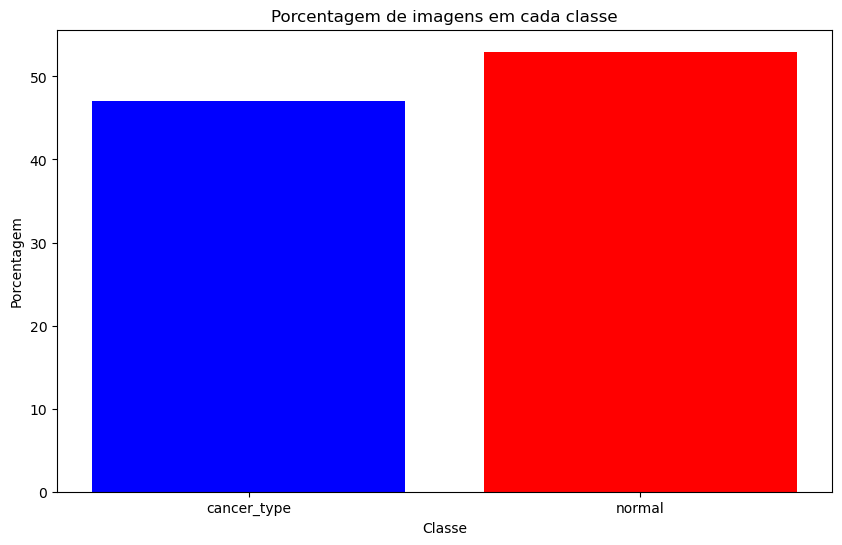

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type        3648     47.02849
normal             4109     52.97151


In [3]:
#Train set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_augmented/train'
plot_image_counts2(folder_path)

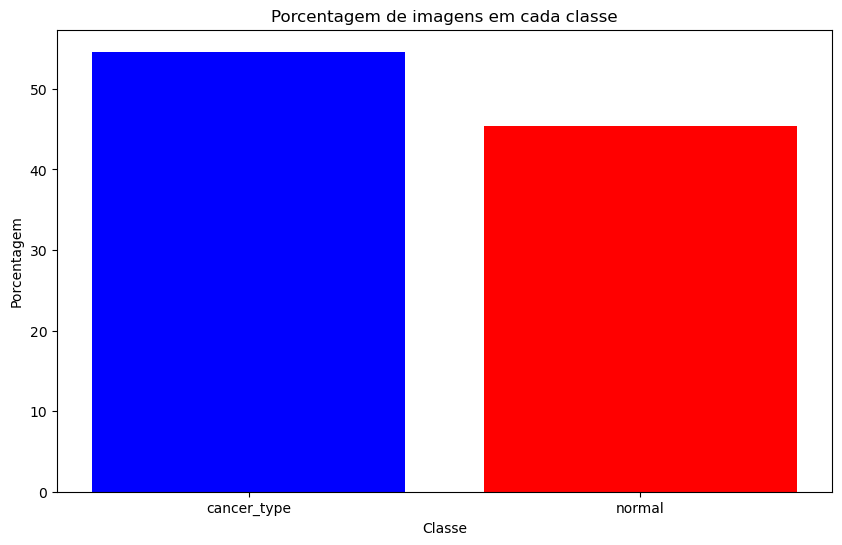

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         361    54.614221
normal              300    45.385779


In [4]:
#Test set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_augmented/test'
plot_image_counts2(folder_path)

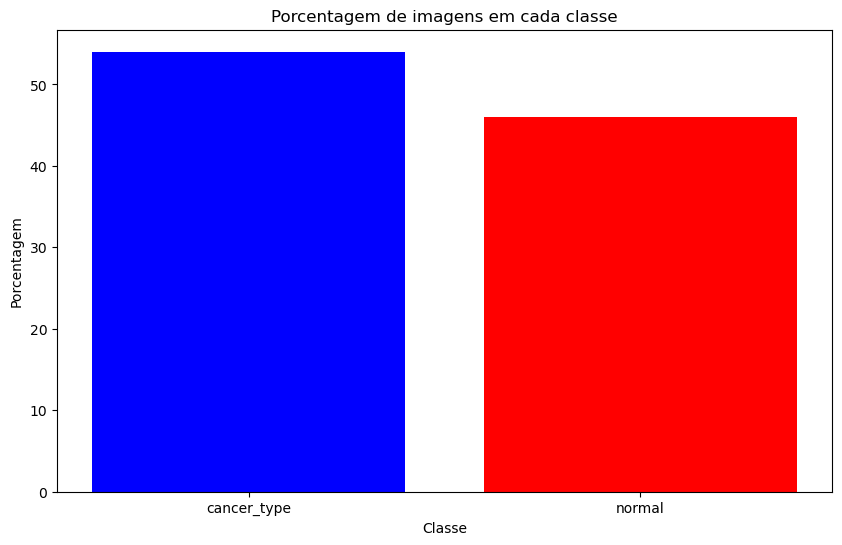

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         235    54.022989
normal              200    45.977011


In [5]:
#Val set binário
folder_path = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_augmented/val'
plot_image_counts2(folder_path)

In [2]:
#Diretórios
train_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_augmented/train'
val_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_augmented/val'
test_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_augmented/test'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 32

#CLasses
num_classes = 2

In [3]:
#Data generators
#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 7757 images belonging to 2 classes.
Found 435 images belonging to 2 classes.
Found 661 images belonging to 2 classes.


In [8]:
#Transfer learning com a densenet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose = 1, restore_best_weights=True)

In [11]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 472, 614,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 478, 620,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 236, 307,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 236, 307,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 236, 307,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 238, 309,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 118, 154,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 118, 154,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 118, 154,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 118, 154,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 118, 154,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 118, 154,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 118, 154,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 118, 154,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 118, 154,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 118, 154,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 118, 154,  │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_schedule])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


243/243 ━━━━━━━━━━━━━━━━━━━━ 1714s 7s/step - accuracy: 0.6303 - loss: 0.7724 - val_accuracy: 0.4897 - val_loss: 0.9019 - learning_rate: 0.0100
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1699s 7s/step - accuracy: 0.6926 - loss: 0.5918 - val_accuracy: 0.5448 - val_loss: 0.7120 - learning_rate: 0.0100
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1700s 7s/step - accuracy: 0.7066 - loss: 0.5727 - val_accuracy: 0.5425 - val_loss: 0.7983 - learning_rate: 0.0100
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1701s 7s/step - accuracy: 0.7355 - loss: 0.5211 - val_accuracy: 0.5471 - val_loss: 0.7915 - learning_rate: 0.0100
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1700s 7s/step - accuracy: 0.7485 - loss: 0.4918 - val_accuracy: 0.5885 - val_loss: 0.6993 - learning_rate: 0.0100
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1700s 7s/step - accuracy: 0.7260 - loss: 0.5598 - val_accuracy: 0.5885 - val_loss: 0.7539 - learning_rate: 0.0100
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1700s 7s/step - accuracy: 0.7423 - loss: 

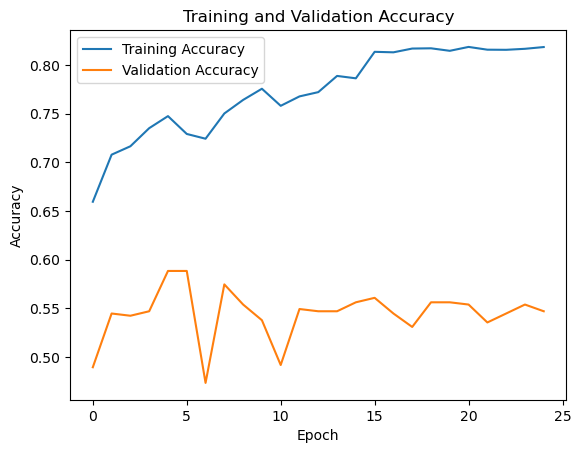

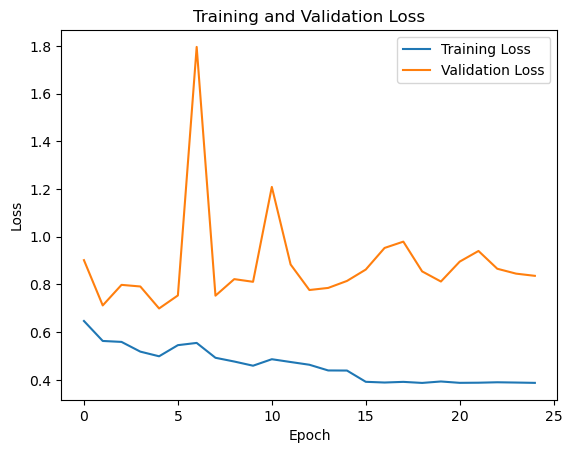

In [13]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.5755 - loss: 0.6995
Test Accuracy: 60.97%
Test Loss: 0.6790


In [15]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

21/21 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

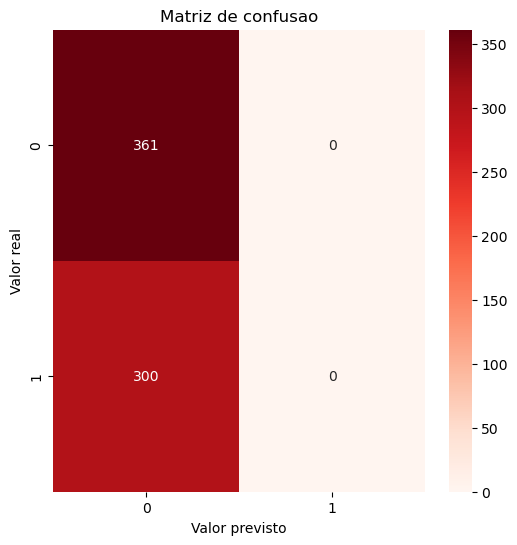

In [17]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [18]:
#Transfer learning com a densenet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose = 1, restore_best_weights=True)

In [21]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 472, 614,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 478, 620,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 236, 307,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 236, 307,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 236, 307,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 238, 309,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 118, 154,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 118, 154,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 118, 154,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 118, 154,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 118, 154,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 118, 154,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 118, 154,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 118, 154,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 118, 154,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 118, 154,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 118, 154,  │      1,024 │ conv2_block1_3_c

 Total params: 24,202,113 (92.32 MB)

 Trainable params: 614,401 (2.34 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_schedule])

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1713s 7s/step - accuracy: 0.6525 - loss: 129.8746 - val_accuracy: 0.5494 - val_loss: 156.6693 - learning_rate: 0.0100
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.8094 - loss: 58.8577 - val_accuracy: 0.4667 - val_loss: 291.9081 - learning_rate: 0.0100
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1706s 7s/step - accuracy: 0.8529 - loss: 44.2042 - val_accuracy: 0.5080 - val_loss: 269.6857 - learning_rate: 0.0100
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.8987 - loss: 28.4777 - val_accuracy: 0.5678 - val_loss: 224.2730 - learning_rate: 0.0100
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1706s 7s/step - accuracy: 0.9287 - loss: 19.4982 - val_accuracy: 0.5402 - val_loss: 248.5959 - learning_rate: 0.0100
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.9062 - loss: 30.8748 - val_accuracy: 0.5287 - val_loss: 283.9193 - learning_rate: 0.0100
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1706s 7s/s

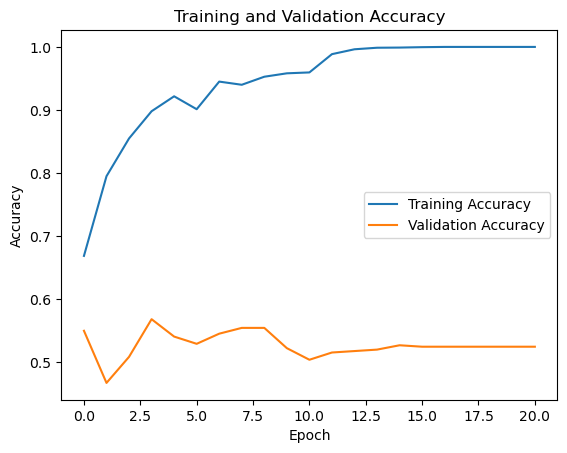

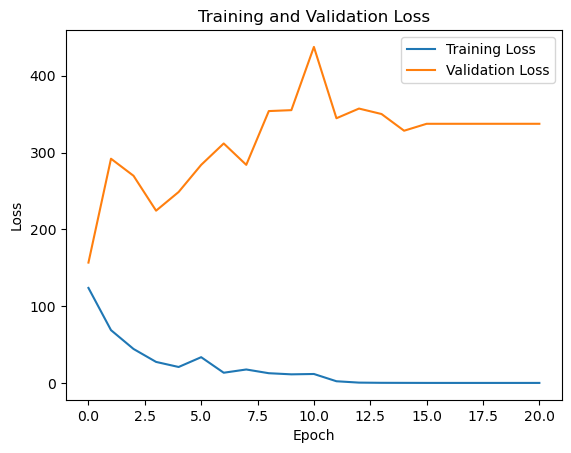

In [23]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 137s 7s/step - accuracy: 0.5277 - loss: 160.8280
Test Accuracy: 54.61%
Test Loss: 154.3913


In [25]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

21/21 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

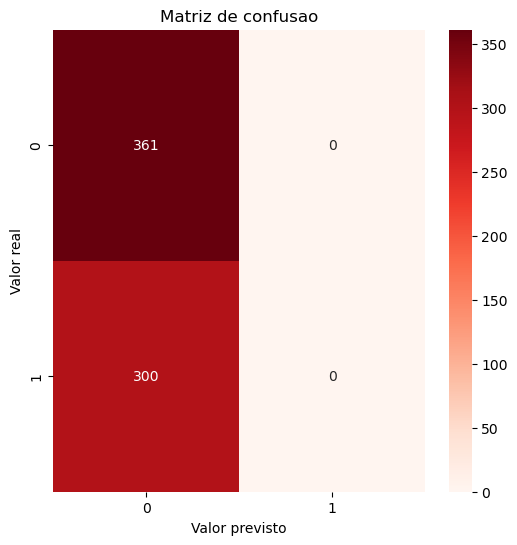

In [27]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [4]:
#Transfer learning com a densenet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose = 1, restore_best_weights=True)

In [8]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


243/243 ━━━━━━━━━━━━━━━━━━━━ 1726s 7s/step - accuracy: 0.6133 - loss: 0.6357 - val_accuracy: 0.4644 - val_loss: 0.7603
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.6463 - loss: 0.5889 - val_accuracy: 0.5011 - val_loss: 0.7205
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1707s 7s/step - accuracy: 0.6722 - loss: 0.5707 - val_accuracy: 0.4874 - val_loss: 0.7379
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.6817 - loss: 0.5650 - val_accuracy: 0.4759 - val_loss: 0.7530
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.6993 - loss: 0.5570 - val_accuracy: 0.4966 - val_loss: 0.7385
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.6918 - loss: 0.5536 - val_accuracy: 0.4989 - val_loss: 0.7431
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1705s 7s/step - accuracy: 0.7018 - loss: 0.5543 - val_accuracy: 0.5448 - val_loss: 0.7049
Epoch 8/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1706s 7s/step - accuracy: 0.7012 - loss: 0.5483 - val_

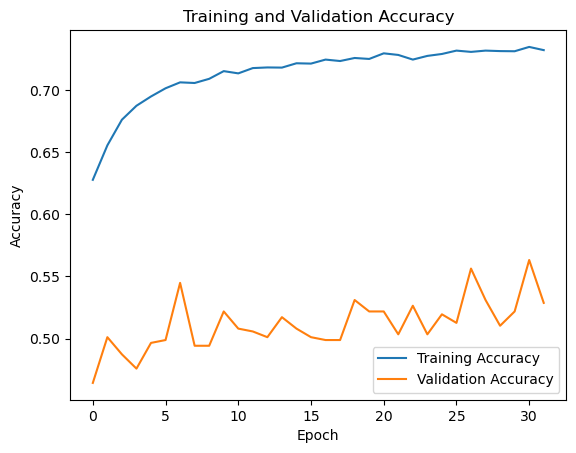

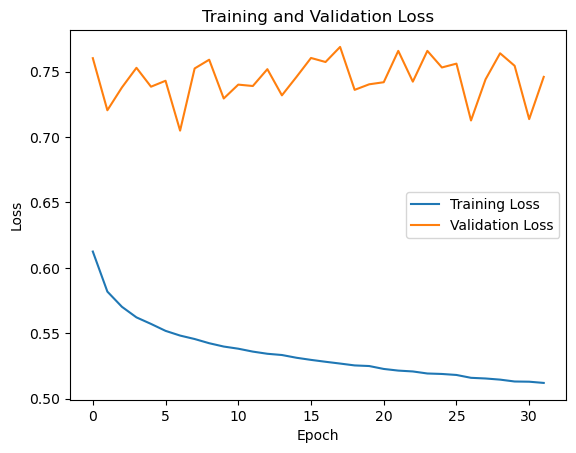

In [9]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.5203 - loss: 0.7099
Test Accuracy: 52.65%
Test Loss: 0.7115


In [11]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

21/21 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

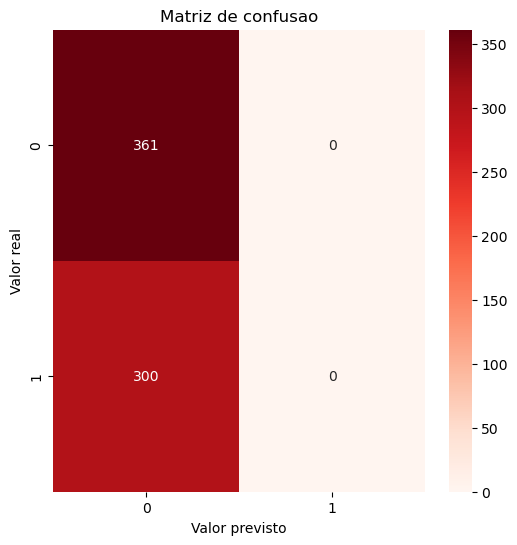

In [13]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [14]:
#Transfer learning com a densenet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [15]:
#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#FAZER DEPOIS COM 0.0001

In [16]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose = 1, restore_best_weights=True)

In [17]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1716s 7s/step - accuracy: 0.6430 - loss: 6.8612 - val_accuracy: 0.5356 - val_loss: 10.6060
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1708s 7s/step - accuracy: 0.7952 - loss: 3.2028 - val_accuracy: 0.5264 - val_loss: 13.7348
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1708s 7s/step - accuracy: 0.8539 - loss: 2.4245 - val_accuracy: 0.5655 - val_loss: 9.6345
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1708s 7s/step - accuracy: 0.9092 - loss: 1.2942 - val_accuracy: 0.5172 - val_loss: 10.9210
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1708s 7s/step - accuracy: 0.9371 - loss: 0.6393 - val_accuracy: 0.5310 - val_loss: 14.0507
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1708s 7s/step - accuracy: 0.9206 - loss: 1.1615 - val_accuracy: 0.5241 - val_loss: 14.2555
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1707s 7s/step - accuracy: 0.9265 - loss: 1.0344 - val_accuracy: 0.5540 - val_loss: 15.7931
Epoch 8/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1708s 7s/step - accuracy: 0.9571 - l

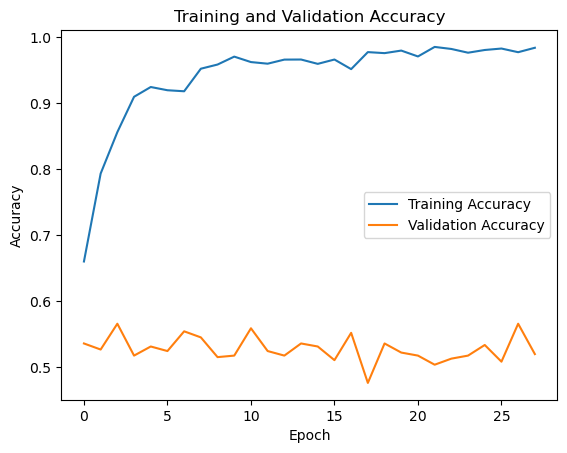

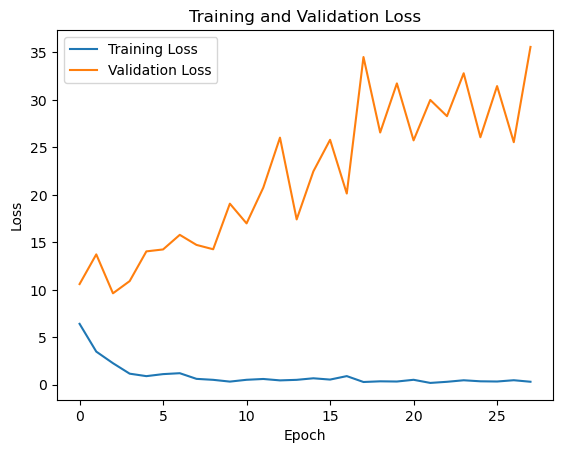

In [18]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.5643 - loss: 10.5675
Test Accuracy: 53.86%
Test Loss: 10.5903


In [20]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

21/21 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [21]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

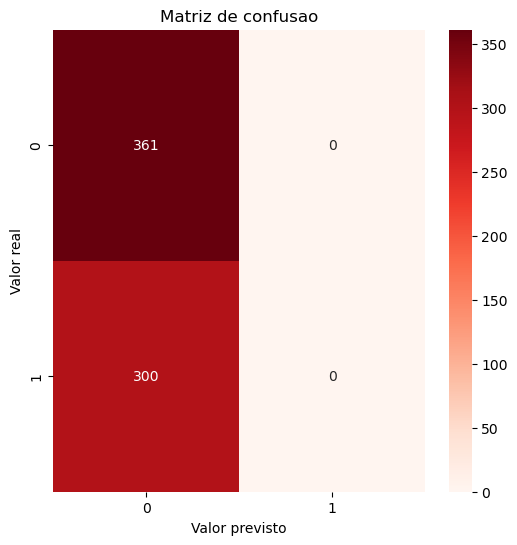

In [22]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [23]:
#Transfer learning com a densenet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.8)(x)

x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)

x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.8)(x)

x = BatchNormalization()(x)

predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#FAZER DEPOIS COM 0.0001

In [25]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose = 1, restore_best_weights=True)

In [26]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1972s 8s/step - accuracy: 0.4931 - loss: 0.8694 - val_accuracy: 0.4644 - val_loss: 0.7038
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1958s 8s/step - accuracy: 0.5077 - loss: 0.7863 - val_accuracy: 0.4667 - val_loss: 0.7025
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1959s 8s/step - accuracy: 0.5177 - loss: 0.7444 - val_accuracy: 0.4736 - val_loss: 0.7010
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1959s 8s/step - accuracy: 0.5254 - loss: 0.7221 - val_accuracy: 0.4644 - val_loss: 0.7011
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1959s 8s/step - accuracy: 0.5237 - loss: 0.7093 - val_accuracy: 0.4644 - val_loss: 0.7000
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1959s 8s/step - accuracy: 0.5318 - loss: 0.6955 - val_accuracy: 0.4667 - val_loss: 0.7016
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 1959s 8s/step - accuracy: 0.5570 - loss: 0.6886 - val_accuracy: 0.4690 - val_loss: 0.7025
Epoch 8/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 2002s 8s/step - accuracy: 0.5790 - loss: 0

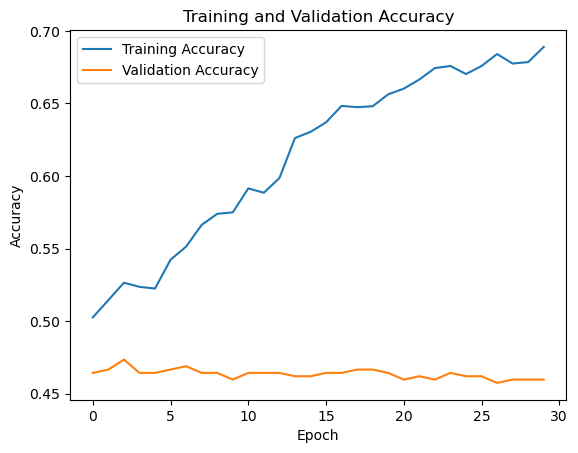

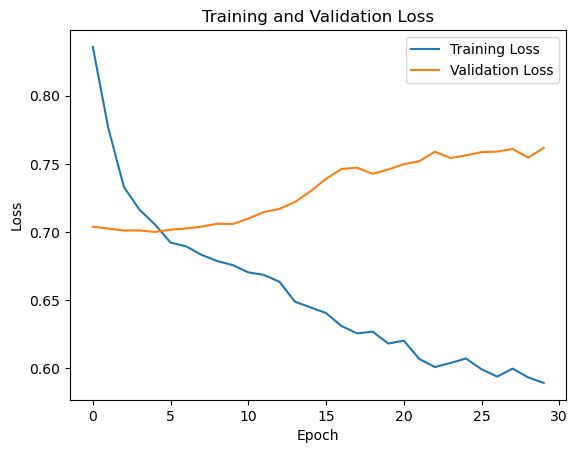

In [27]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 0.4946 - loss: 0.6965
Test Accuracy: 46.75%
Test Loss: 0.7018


In [29]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

21/21 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [30]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

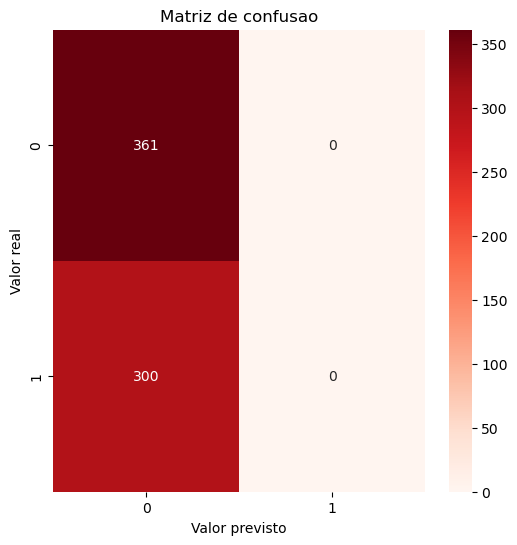

In [31]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()